In [3]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 31.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd

train = pd.read_json("/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/dataset/train.json")
dev = pd.read_json("/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/dataset/dev.json")
test = pd.read_json("/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/dataset/test.json")

In [ ]:
train = train.sample(n=20000, random_state = 42)
dev = dev.sample(n=2000, random_state = 42)
test = test.sample(n=2000, random_state = 42)

In [ ]:
import os

for fname in [
    "/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/phoMT.py",
    "/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/vocab.py",
    "/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/Seq2SeqLSTM.py",
    "/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/train_lstm.py"

]:
  open(f"{fname}", "w").close()

In [ ]:
%%writefile /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/vocab.py
import torch
import re
import json
import os
import string

class Vocab:
  def __init__(self, path: str, src_language: str, tgt_language: str):
    self.initialize_special_tokens()
    self.src_language = src_language
    self.tgt_language = tgt_language
    self.make_vocab(path, src_language, tgt_language)

  def initialize_special_tokens(self) -> None:
    self.bos_token = "<bos>"
    self.eos_token = "<eos>"
    self.pad_token = "<pad>"
    self.unk_token = "<unk>"

    self.specials = [self.pad_token, self.bos_token, self.eos_token, self.unk_token]

    self.pad_idx = 0
    self.bos_idx = 1
    self.eos_idx = 2
    self.unk_idx = 3

    self.special_ids = [self.pad_idx, self.bos_idx, self.eos_idx, self.unk_idx]

  def make_vocab(self, path: str, src_language: str, tgt_language: str):
    json_files = os.listdir(path)
    src_words = set()
    tgt_words = set()

    print("Building vocabulary...")
    for json_file in json_files:
      file_path = os.path.join(path, json_file)
      # Chỉ đọc file json
      if not json_file.endswith('.json'):
          continue

      data = json.load(open(file_path, encoding='utf-8'))
      for item in data:
        src_sentence = item[src_language]
        tgt_sentence = item[tgt_language]

        src_tokens = self.preprocess_sentence(src_sentence)
        tgt_tokens = self.preprocess_sentence(tgt_sentence)

        src_words.update(src_tokens)
        tgt_words.update(tgt_tokens)

    # Tạo src dictionary
    src_i2s = self.specials + list(src_words) # Dùng list thay vì tuple để dễ xử lý
    self.src_i2s = {i: tok for i, tok in enumerate(src_i2s)}
    self.src_s2i = {tok: i for i, tok in enumerate(src_i2s)}

    # Tạo tgt dictionary
    tgt_i2s = self.specials + list(tgt_words)
    self.tgt_i2s = {i: tok for i, tok in enumerate(tgt_i2s)}
    self.tgt_s2i = {tok: i for i, tok in enumerate(tgt_i2s)}

    print(f"Vocab created. Src tokens: {len(self.src_i2s)}, Tgt tokens: {len(self.tgt_i2s)}")

  @property
  def total_src_tokens(self) -> int:
    return len(self.src_i2s)

  @property
  def total_tgt_tokens(self) -> int:
    return len(self.tgt_i2s)

  def preprocess_sentence(self, sentence: str) -> list:
    # Xử lý: Xóa dấu câu -> chữ thường -> tách từ (split)
    translator = str.maketrans("", "", string.punctuation)
    sentence = sentence.lower()
    sentence = sentence.translate(translator)
    # Phải split để trả về list các từ, không phải list các ký tự
    return sentence.split()

  def encode_sentence(self, sentence: str, language: str) -> torch.Tensor:
    tokens = self.preprocess_sentence(sentence)

    if language == self.src_language:
        s2i = self.src_s2i
    elif language == self.tgt_language:
        s2i = self.tgt_s2i
    else:
        raise ValueError(f"Language {language} not supported")

    vec = [s2i.get(token, self.unk_idx) for token in tokens] # Dùng .get để an toàn hơn

    vec = [self.bos_idx] + vec + [self.eos_idx]

    return torch.tensor(vec, dtype=torch.long)

  def decode_sentence(self, tensor: torch.Tensor, language: str) -> list[str]:
    if isinstance(tensor, torch.Tensor):
        sentence_ids = tensor.tolist()
    else:
        sentence_ids = tensor

    if language == self.src_language:
        i2s = self.src_i2s
    else:
        i2s = self.tgt_i2s

    words = []
    for idx in sentence_ids:
        # Bỏ qua các token đặc biệt khi decode để ra câu tự nhiên
        if idx not in self.special_ids:
            words.append(i2s.get(idx, self.unk_token))

    return " ".join(words)

Overwriting /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/vocab.py


In [ ]:
%%writefile /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/phoMT.py
import torch
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
import json
from vocab import Vocab

def collate_fn(batch: list[dict]) -> dict:
    # Lấy danh sách các tensor nguồn và đích từ batch
    src_batch = [item["src"] for item in batch]
    tgt_batch = [item["tgt"] for item in batch]

    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_padded = pad_sequence(tgt_batch, batch_first=True, padding_value=0)

    return {
        "src": src_padded,
        "tgt": tgt_padded
    }

class phoMTDataset(Dataset):
    def __init__(self, path: str, vocab: Vocab):
        # Load dữ liệu
        self.data = json.load(open(path, encoding="utf-8"))
        self.vocab = vocab

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int):
        item = self.data[index]

        # 1. Lấy text từ file JSON (Key trong file JSON là 'english' và 'vietnamese')
        src_text = item["english"]
        tgt_text = item["vietnamese"]

        # 2. Mã hóa
        encoded_src = self.vocab.encode_sentence(src_text, self.vocab.src_language)
        encoded_tgt = self.vocab.encode_sentence(tgt_text, self.vocab.tgt_language)

        # 3. Trả về dictionary với key chuẩn 'src' và 'tgt'
        return {
            "src": encoded_src,
            "tgt": encoded_tgt
        }

Overwriting /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/phoMT.py


In [ ]:
%%writefile /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/Seq2SeqLSTM.py
import torch
from torch import nn
import random

class Seq2SeqLSTM(nn.Module):
    def __init__(self, d_model: int, n_encoder: int, n_decoder: int, dropout: float, vocab):
        super().__init__()
        self.vocab = vocab

        # 1. Embedding
        # Encoder embedding
        self.src_embedding = nn.Embedding(
            num_embeddings=vocab.total_src_tokens,
            embedding_dim=d_model,
            padding_idx=vocab.pad_idx
        )

        # Decoder embedding (input size = 2*d_model để khớp với hidden state ghép từ encoder)
        self.tgt_embedding = nn.Embedding(
            num_embeddings=vocab.total_tgt_tokens,
            embedding_dim=2 * d_model,
            padding_idx=vocab.pad_idx
        )

        # 2. Encoder (Bidirectional = True)
        self.encoder = nn.LSTM(
            input_size=d_model,
            hidden_size=d_model,
            num_layers=n_encoder,
            batch_first=True,
            dropout=dropout if n_encoder > 1 else 0,
            bidirectional=True
        )

        # 3. Decoder (Bidirectional = False)
        # Hidden size = 2 * d_model (do ghép 2 chiều từ Encoder)
        self.decoder = nn.LSTM(
            input_size=2 * d_model,
            hidden_size=2 * d_model,
            num_layers=n_decoder,
            batch_first=True,
            dropout=dropout if n_decoder > 1 else 0,
            bidirectional=False
        )

        # 4. Output Head
        self.output_head = nn.Linear(
            in_features=2 * d_model,
            out_features=vocab.total_tgt_tokens
        )

    def _process_encoder_states(self, hidden, cell):
        # Lấy kích thước hiện tại
        num_layers_x2, batch_size, hidden_dim = hidden.shape
        num_layers = num_layers_x2 // 2

        # 1. Tách chiều forward và backward: (num_layers, 2, batch, hidden)
        hidden = hidden.view(num_layers, 2, batch_size, hidden_dim)
        cell = cell.view(num_layers, 2, batch_size, hidden_dim)

        # 2. Ghép (Concatenate) 2 chiều lại: (num_layers, batch, 2*hidden)
        # dim=2 tương ứng với chiều hidden_dim
        hidden = torch.cat((hidden[:, 0, :, :], hidden[:, 1, :, :]), dim=2)
        cell = torch.cat((cell[:, 0, :, :], cell[:, 1, :, :]), dim=2)

        return hidden, cell

    def forward(self, src: torch.Tensor, tgt: torch.Tensor):
        # Encoder
        embedded_src = self.src_embedding(src)
        _, (hidden, cell) = self.encoder(embedded_src)

        # Chuyển đổi hidden/cell state
        hidden, cell = self._process_encoder_states(hidden, cell)

        # Decoder
        embedded_tgt = self.tgt_embedding(tgt)
        decoder_outputs, _ = self.decoder(embedded_tgt, (hidden, cell))

        # Output Projection
        logits = self.output_head(decoder_outputs)
        return logits

    def predict(self, src: torch.Tensor, max_len: int = 100):
        self.eval()
        device = src.device

        bs = src.shape[0]

        # 1. Encoder Pass
        with torch.no_grad():
            embedded_src = self.src_embedding(src)
            _, (hidden, cell) = self.encoder(embedded_src)
            hidden, cell = self._process_encoder_states(hidden, cell)

        # 2. Chuẩn bị token đầu tiên <bos>
        # Giả sử self.vocab.bos_idx là index của <bos>
        input_token = torch.tensor([self.vocab.bos_idx] * bs, device=device).unsqueeze(1) # (Batch, 1)

        outputs = []

        # 3. Vòng lặp sinh từ (Autoregressive)
        for _ in range(max_len):
            embedded_input = self.tgt_embedding(input_token) # (Batch, 1, 2*Dim)

            # Decoder bước t
            decoder_output, (hidden, cell) = self.decoder(embedded_input, (hidden, cell))

            # Dự đoán từ tiếp theo
            logit = self.output_head(decoder_output.squeeze(1)) # (Batch, Vocab)
            pred_token = logit.argmax(dim=1) # (Batch)

            # Lưu kết quả
            outputs.append(pred_token.unsqueeze(1))

            # Input cho bước t+1 là output của bước t
            input_token = pred_token.unsqueeze(1)

        return torch.cat(outputs, dim=1)

Overwriting /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/Seq2SeqLSTM.py


In [1]:
%%writefile /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/train_lstm.py
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Subset # Thêm import cần thiết
import numpy as np
import os
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
from phoMT import collate_fn, phoMTDataset
from vocab import Vocab
from Seq2SeqLSTM import Seq2SeqLSTM
# Import Metrics
try:
    from torchmetrics.text.rouge import ROUGEScore
except ImportError:
    print("Vui lòng cài đặt torchmetrics: pip install torchmetrics")
    exit()

# --- Config ---
device = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_DIR = "/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/1_LSTM/"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# --- Logging Setup ---
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(os.path.join(CHECKPOINT_DIR, "training.log"), mode='a'),
        logging.StreamHandler()
    ],
    force=True
)

def indices_to_text(indices, vocab, is_target=True):
    tokens = []
    # Chọn từ điển phù hợp
    i2s = vocab.tgt_i2s if is_target else vocab.src_i2s

    for idx in indices:
        if isinstance(idx, torch.Tensor):
            idx = idx.item()

        # Dừng nếu gặp <eos> (chỉ có trong Target/Translation)
        if is_target and idx == vocab.eos_idx:
            break

        if idx != vocab.pad_idx:
            # Bỏ qua <bos> chỉ cho Target/Translation
            if is_target and idx == vocab.bos_idx:
                continue

            # Dùng .get để an toàn, nếu không tìm thấy thì trả về <unk>
            token = i2s.get(idx, vocab.unk_token)
            tokens.append(token)

        # Dừng nếu gặp <eos> (chỉ có trong Source)
        if not is_target and idx == vocab.eos_idx:
             break

    return " ".join(tokens)

def train(model: nn.Module, dataloader: DataLoader, epoch: int, loss_fn, optimizer):
    model.train()
    running_loss = []

    with tqdm(dataloader, desc=f"Epoch {epoch} - Training") as pbar:
        for item in pbar:
            src = item['src'].to(device)
            tgt = item['tgt'].to(device)

            optimizer.zero_grad()

            # Teacher forcing
            decoder_input = tgt[:, :-1]
            targets = tgt[:, 1:]

            logits = model(src, decoder_input)

            # Flatten để tính loss
            # logits: (bs*len, vocab_size), targets: (bs*len)
            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), targets.reshape(-1))

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss.append(loss.item())
            pbar.set_postfix({"loss": np.mean(running_loss)})

    avg_loss = np.mean(running_loss)
    logging.info(f"Epoch {epoch} - Training Loss: {avg_loss:.4f}")
    return avg_loss

def evaluate(model: nn.Module, dataloader: DataLoader, epoch: int, loss_fn, vocab):
    model.eval()
    running_loss = []
    rouge_metric = ROUGEScore().to(device)

    all_preds_text = []
    all_targets_text = []

    # Flag để chỉ in ra một ví dụ duy nhất mỗi epoch
    example_printed = False

    with torch.no_grad():
        for item in tqdm(dataloader, desc=f"Epoch {epoch} - Evaluating"):
            src = item['src'].to(device)
            tgt = item['tgt'].to(device)

            # 1. Validation Loss
            decoder_input = tgt[:, :-1]
            targets = tgt[:, 1:]
            logits = model(src, decoder_input)
            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), targets.reshape(-1))
            running_loss.append(loss.item())

            # 2. ROUGE-L Prediction
            # Sinh văn bản (Inference)
            generated_tokens = model.predict(src, max_len=tgt.shape[1] + 10)

            # Xử lý trường hợp generated_tokens rỗng
            if generated_tokens.shape[1] == 0:
                generated_tokens = torch.zeros(tgt.shape[0], 1, dtype=torch.long, device=device)

            for i in range(len(tgt)):
                # Decode output của model (Translation)
                pred_seq = generated_tokens[i].tolist()
                pred_text = indices_to_text(pred_seq, vocab, is_target=True)

                # Decode nhãn thật (Reference)
                tgt_seq = tgt[i].tolist()
                tgt_text = indices_to_text(tgt_seq, vocab, is_target=True)

                # LOGIC IN VÍ DỤ
                if not example_printed:
                    # Decode Source (English)
                    src_seq = src[i].tolist()
                    src_text = indices_to_text(src_seq, vocab, is_target=False)

                    logging.info(f"\n--- Example Translation (Epoch {epoch}) ---")
                    logging.info(f"Source:      {src_text}")
                    logging.info(f"Reference:   {tgt_text}")
                    logging.info(f"Translation: {pred_text}")
                    logging.info("-" * 45)
                    example_printed = True # Đảm bảo chỉ in một lần

                all_preds_text.append(pred_text)
                all_targets_text.append(tgt_text)

    # Tính ROUGE trên tập Validation
    if len(all_preds_text) > 0:
        rouge_scores = rouge_metric(all_preds_text, all_targets_text)
        rouge_l = rouge_scores['rougeL_fmeasure'].item()
    else:
        rouge_l = 0.0

    avg_loss = np.mean(running_loss)
    logging.info(f"Epoch {epoch} - Val Loss: {avg_loss:.4f} | ROUGE-L: {rouge_l:.4f}")

    return avg_loss, rouge_l

def visualize_metrics(train_losses, val_losses, rouge_scores):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='s')
    plt.title("Loss History")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, rouge_scores, label='Val ROUGE-L', marker='^', color='green')
    plt.title("ROUGE-L Score History")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    logging.info("="*50)
    logging.info(f"Starting training on Device: {device}")
    vocab = Vocab(
        path="/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/dataset",
        src_language="english",
        tgt_language="vietnamese"
    )

    # Lấy toàn bộ dataset
    train_dataset_full = phoMTDataset("/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/dataset/train.json", vocab)
    dev_dataset_full = phoMTDataset("/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/dataset/dev.json", vocab)
    test_dataset_full = phoMTDataset("/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/dataset/test.json", vocab)

    train_size = 20000
    dev_test_size = 2000

    # Lấy ngẫu nhiên 20k train
    train_indices = torch.randperm(len(train_dataset_full))[:train_size].tolist()
    train_dataset = Subset(train_dataset_full, train_indices)

    # Lấy ngẫu nhiên 2k dev
    dev_indices = torch.randperm(len(dev_dataset_full))[:dev_test_size].tolist()
    dev_dataset = Subset(dev_dataset_full, dev_indices)

    # Lấy ngẫu nhiên 2k test
    test_indices = torch.randperm(len(test_dataset_full))[:dev_test_size].tolist()
    test_dataset = Subset(test_dataset_full, test_indices)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Khởi tạo model (sử dụng Luong Attention đã sửa ở bước trước)
    model = Seq2SeqLSTM(
        d_model=256,
        n_encoder=3,
        n_decoder=3,
        dropout=0.3,
        vocab=vocab
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss(ignore_index=vocab.pad_idx)

    checkpoint_path = os.path.join(CHECKPOINT_DIR, "best_lstm_mt.pt")
    best_rouge = 0.0
    start_epoch = 0

    if os.path.exists(checkpoint_path):
        ckpt = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        start_epoch = ckpt['epoch']
        best_rouge = ckpt.get('best_rouge', 0.0)
        logging.info(f"Resumed from epoch {start_epoch}, Best ROUGE: {best_rouge:.4f}")

    train_losses, val_losses, val_rouges = [], [], []
    patience = 0

    for epoch in range(start_epoch + 1, 20):
        logging.info(f"\n--- Epoch {epoch} ---")

        t_loss = train(model, train_loader, epoch, loss_fn, optimizer)
        # Trong evaluate sẽ in ra 1 ví dụ
        v_loss, v_rouge = evaluate(model, dev_loader, epoch, loss_fn, vocab)

        train_losses.append(t_loss)
        val_losses.append(v_loss)
        val_rouges.append(v_rouge)

        if v_rouge > best_rouge:
            best_rouge = v_rouge
            patience = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_rouge': best_rouge
            }, checkpoint_path)
            logging.info(f"✓ Saved Best Model (ROUGE-L: {best_rouge:.4f})")
        else:
            patience += 1
            logging.info(f"No improvement. Patience: {patience}/10")
            if patience >= 10:
                logging.info("Early stopping!")
                break

    logging.info("\nEvaluating on Test Set with Best Model...")
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])

    test_loss, test_rouge = evaluate(model, test_loader, 0, loss_fn, vocab)
    logging.info(f"Test Loss: {test_loss:.4f} | Test ROUGE-L: {test_rouge:.4f}")

    visualize_metrics(train_losses, val_losses, val_rouges)

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        logging.error(f"Error: {str(e)}", exc_info=True)

Overwriting /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/train_lstm.py


2025-12-10 13:59:21,964 - INFO - ==================================================
2025-12-10 13:59:21,966 - INFO - Starting training on Device: cuda


Building vocabulary...
Vocab created. Src tokens: 19835, Tgt tokens: 7839


2025-12-10 13:59:22,926 - INFO - 
--- Epoch 1 ---
Epoch 1 - Training: 100%|██████████| 625/625 [00:48<00:00, 12.88it/s, loss=6.05]
2025-12-10 14:00:11,449 - INFO - Epoch 1 - Training Loss: 6.0546
Epoch 1 - Evaluating: 100%|██████████| 63/63 [00:03<00:00, 17.15it/s]
2025-12-10 14:00:21,729 - INFO - Epoch 1 - Val Loss: 5.8840 | ROUGE-L: 0.2838
2025-12-10 14:00:22,502 - INFO - ✓ Saved Best Model (ROUGE-L: 0.2838)
2025-12-10 14:00:22,504 - INFO - 
--- Epoch 2 ---
Epoch 2 - Training: 100%|██████████| 625/625 [00:48<00:00, 12.81it/s, loss=5.13]
2025-12-10 14:01:11,286 - INFO - Epoch 2 - Training Loss: 5.1266
Epoch 2 - Evaluating: 100%|██████████| 63/63 [00:03<00:00, 17.41it/s]
2025-12-10 14:01:20,851 - INFO - Epoch 2 - Val Loss: 5.3705 | ROUGE-L: 0.3036
2025-12-10 14:01:21,592 - INFO - ✓ Saved Best Model (ROUGE-L: 0.3036)
2025-12-10 14:01:21,594 - INFO - 
--- Epoch 3 ---
Epoch 3 - Training: 100%|██████████| 625/625 [00:49<00:00, 12.64it/s, loss=4.64]
2025-12-10 14:02:11,041 - INFO - Epoch 3 

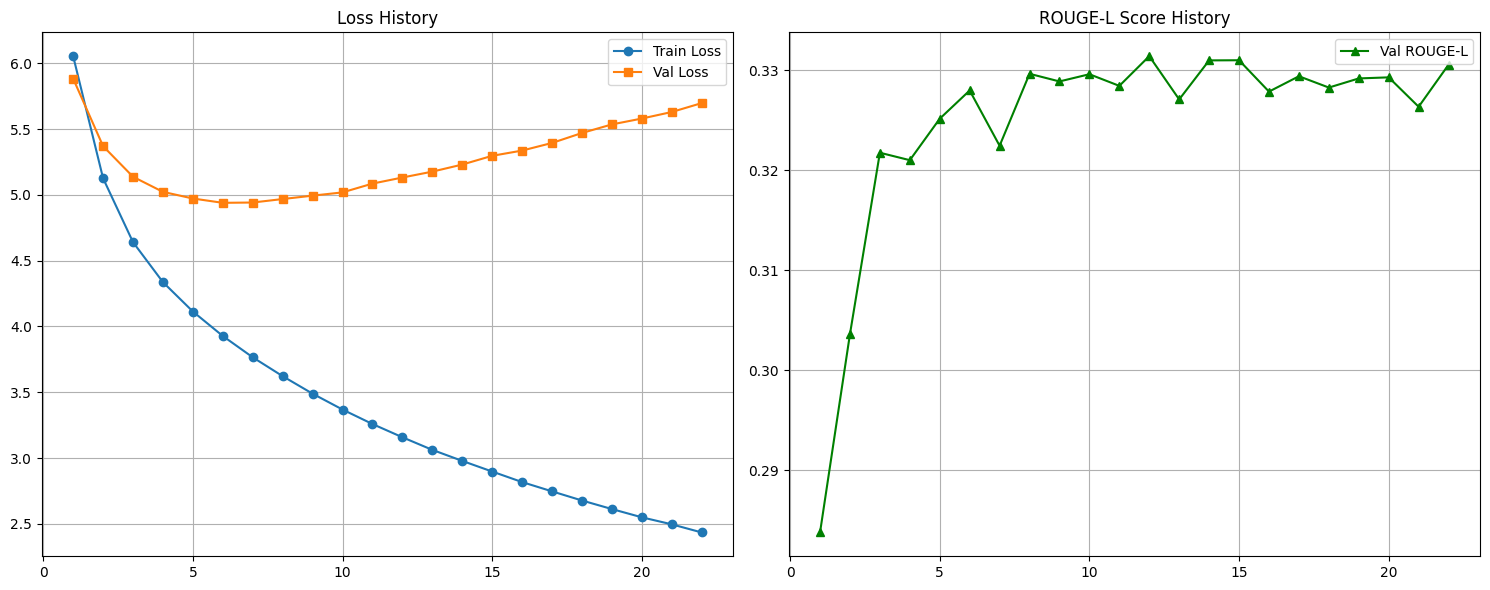

<Figure size 640x480 with 0 Axes>

In [ ]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4')
%run /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/train_lstm.py

2025-12-16 13:13:34,555 - INFO - ==================================================
2025-12-16 13:13:35,111 - INFO - Starting training on Device: cuda


Building vocabulary...
Vocab created. Src tokens: 19835, Tgt tokens: 7839


2025-12-16 13:13:45,956 - INFO - Resumed from epoch 12, Best ROUGE: 0.3314
2025-12-16 13:13:45,957 - INFO - 
--- Epoch 13 ---
Epoch 13 - Training: 100%|██████████| 625/625 [00:48<00:00, 12.93it/s, loss=6.01]
2025-12-16 13:14:34,300 - INFO - Epoch 13 - Training Loss: 6.0073
Epoch 13 - Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]2025-12-16 13:14:36,158 - INFO - 
--- Example Translation (Epoch 13) ---
2025-12-16 13:14:36,160 - INFO - Source:      <bos> we can build lots of other words on each of these bases like doubtful and doubtless or doublet and redouble and doubloon <eos>
2025-12-16 13:14:36,162 - INFO - Reference:   chúng ta có thể xây dựng thêm rất nhiều từ khác từ mỗi một từ trong hai từ ở trên như doubtful và doubtless hay doubtlet và redouble và doubloon
2025-12-16 13:14:36,164 - INFO - Translation: chúng ta có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể làm thế giới
2025-12-16 13:14:36,165 - INFO - ---------------------------------------------
Epoch

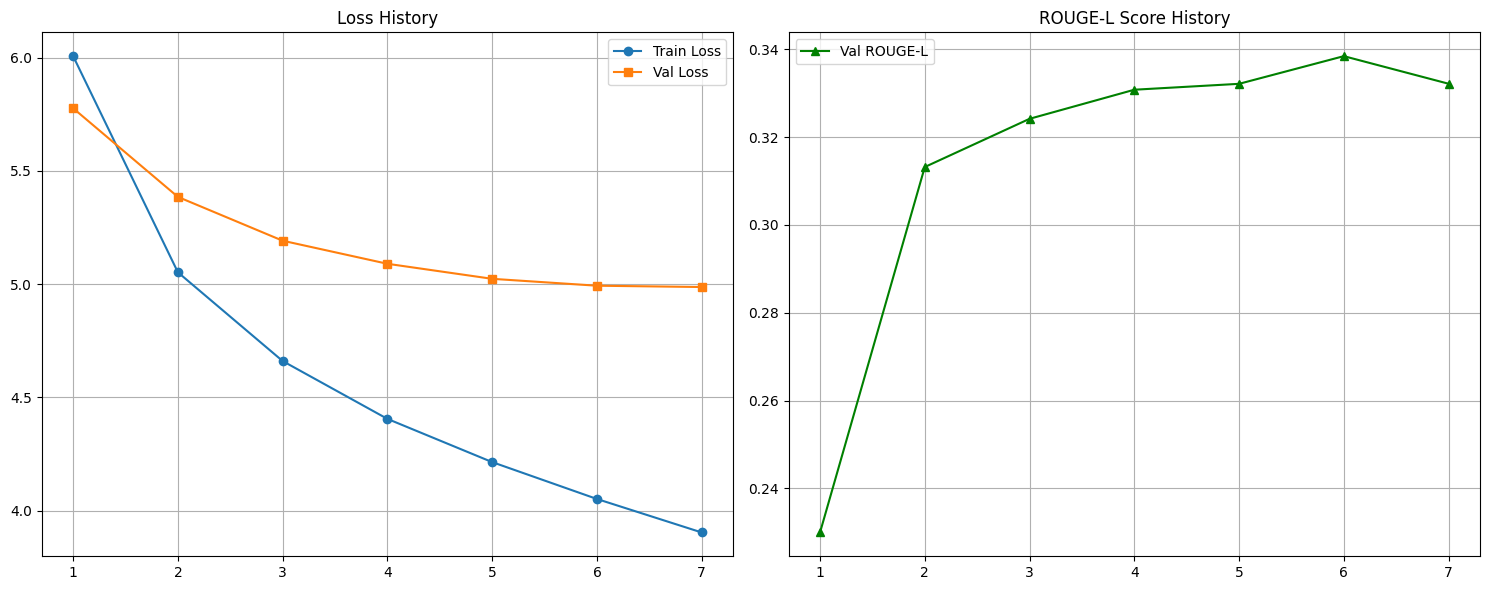

<Figure size 640x480 with 0 Axes>

In [4]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4')
%run /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/train_lstm.py